In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 20
N_CLASSES = 6

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/My Drive/6thProjects/Deep Learning project/train',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2413 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[2 0 5 2 2 4 3 4 2 2 0 2 4 5 3 0 5 5 0 0 2 4 5 5 2 0 3 4 5 5 0 2 0 0 2 2 4
 5 4 4 4 1 0 2 2 4 3 4 2 5 2 3 5 2 0 2 4 4 0 5 4 3 1 4]


In [7]:
# Create a mapping between numerical labels and class names
class_names = {
    0: 'Loose Silky-bent',
    1: 'Maize',
    2: 'Scentless Mayweed',
    3: 'Shepherds Purse',
    4: 'Small-flowered Cranesbill',
    5: 'Sugar beet'
}

unique_labels = set()

for _, labels_batch in dataset.take(1):
    unique_labels.update(labels_batch.numpy())

print("Unique Labels/Classes in the Dataset:", unique_labels)

# Convert numerical labels to class names for visualization
class_names_batch = [class_names[label] for label in labels_batch.numpy()]

print("Class names batch:", class_names_batch)


Unique Labels/Classes in the Dataset: {0, 1, 2, 3, 4, 5}
Class names batch: ['Scentless Mayweed', 'Sugar beet', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Sugar beet', 'Loose Silky-bent', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Maize', 'Scentless Mayweed', 'Sugar beet', 'Loose Silky-bent', 'Sugar beet', 'Maize', 'Maize', 'Loose Silky-bent', 'Loose Silky-bent', 'Sugar beet', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Scentless Mayweed', 'Sugar beet', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Sugar beet', 'Maize', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Small-flowered Cranesbill', 'Sugar beet', 'Loose Silky-bent', 'Loose Silky-bent', 'Small-flowered Cranesbill', 'Shepherds Purse', 'Loose Silky-bent', 'Scentless Mayweed', 'Sugar beet

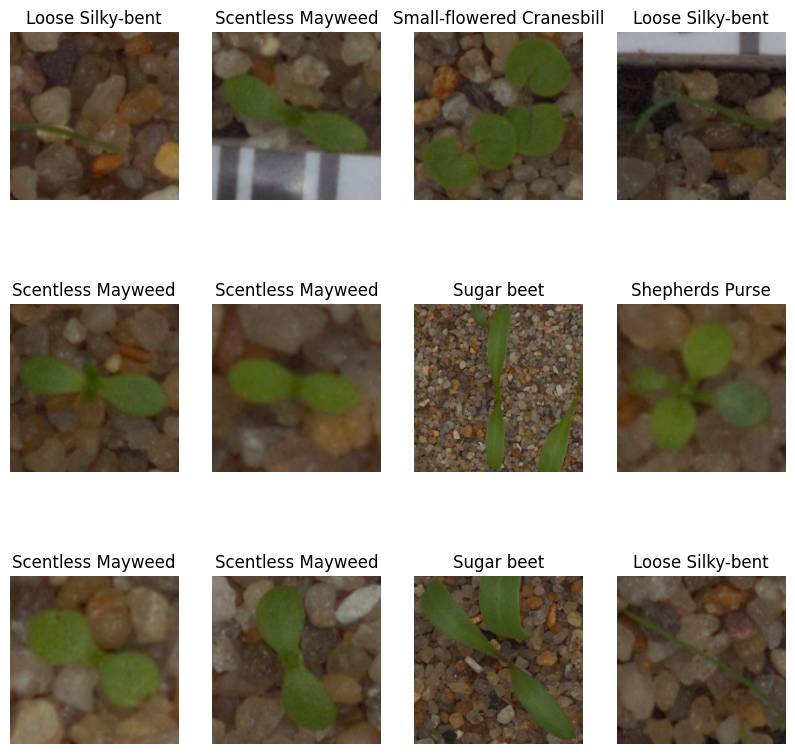

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):  # Display examples from 3 batches
    labels_batch_np = labels_batch.numpy()  # Convert the entire labels_batch tensor to a NumPy array
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # 3 batches * 4 subplots per batch
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # Use the NumPy array as an index in the class_names dictionary
        label_key = labels_batch_np[i]
        plt.title(class_names[label_key])

        plt.axis("off")

plt.show()

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

30

In [12]:
len(val_ds)

3

In [13]:
len(test_ds)

5

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4),
])

In [17]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
model.fit(
        train_ds_augmented,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/20
30/30 [==============================] - 451s 2s/step - loss: 1.7808 - accuracy: 0.2536 - val_loss: 1.7205 - val_accuracy: 0.2500
Epoch 2/20
30/30 [==============================] - 20s 656ms/step - loss: 1.6881 - accuracy: 0.2804 - val_loss: 1.6196 - val_accuracy: 0.2604
Epoch 3/20
30/30 [==============================] - 19s 639ms/step - loss: 1.5593 - accuracy: 0.3735 - val_loss: 1.3664 - val_accuracy: 0.4896
Epoch 4/20
30/30 [==============================] - 20s 664ms/step - loss: 1.3154 - accuracy: 0.5118 - val_loss: 1.0033 - val_accuracy: 0.6302
Epoch 5/20
30/30 [==============================] - 18s 585ms/step - loss: 1.1527 - accuracy: 0.5686 - val_loss: 0.9363 - val_accuracy: 0.6979
Epoch 6/20
30/30 [==============================] - 20s 662ms/step - loss: 1.0510 - accuracy: 0.5986 - val_loss: 0.7719 - val_accuracy: 0.7240
Epoch 7/20
30/30 [==============================] - 19s 640ms/step - loss: 0.9507 - accuracy: 0.6244 - val_loss: 0.7249 - val_accuracy: 0.7292
E

In [22]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 30s 51ms/step - loss: 0.6224 - accuracy: 0.7656


In [23]:
score = model.evaluate(train_ds)

30/30 [==============================] - 1s 39ms/step - loss: 0.5519 - accuracy: 0.7985


In [24]:
scores

[0.6224215626716614, 0.765625]

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


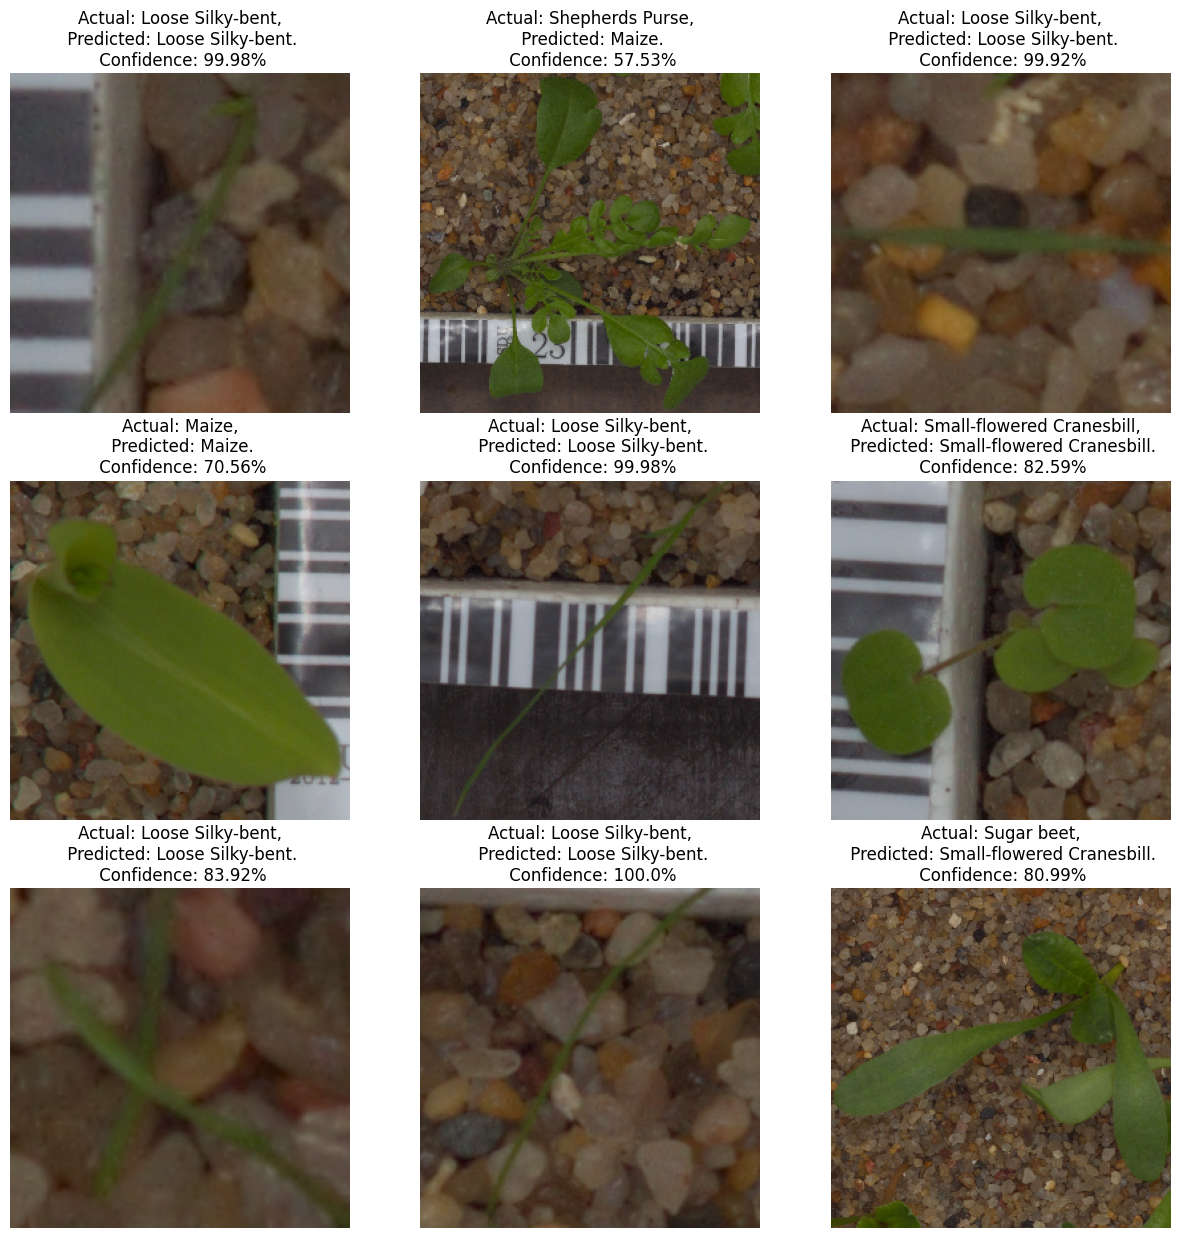

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]


        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming you have a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Collect all unique class names from the training dataset
all_class_names = ['Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']
label_encoder.fit(all_class_names)

# Iterate through the test dataset to collect true and predicted labels
for images, labels in test_ds:
    for i in range(len(images)):
        try:
            true_labels.append(label_encoder.transform([class_names[labels[i].numpy()]])[0])
        except KeyError:
            # Handle unseen label gracefully
            print(f"Unseen label: {class_names[labels[i].numpy()]}")
            continue

        # Using your predict function
        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(label_encoder.transform([predicted_class])[0])

# Convert lists to numpy arrays for precision calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and f1-score with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')




1/1 [==============================] - 0s 18ms/step
Precision: 0.77
Recall: 0.77
F1-score: 0.76


In [34]:
# Calculate precision with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')

Precision: 0.77


In [35]:
# Calculate recall with zero_division parameter
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Recall: {recall:.2f}')

Recall: 0.77


In [36]:
# Calculate precision with zero_division parameter
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)
print(f'F1-score: {f1:.2f}')

F1-score: 0.76


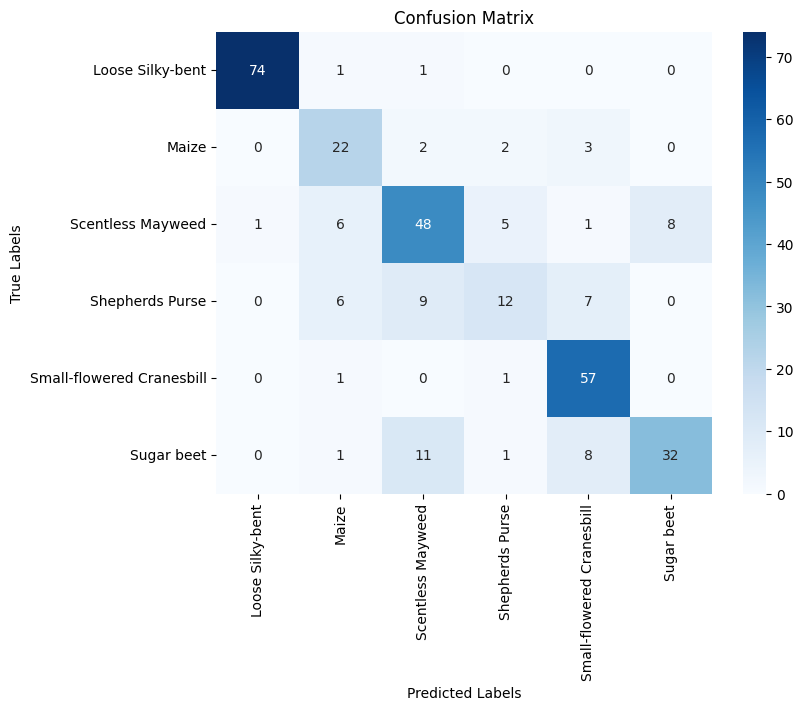

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names for visualization
class_names =  ['Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()